# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import random
import anthropic
import whisper

In [2]:
# Initialization

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

MODEL = "gpt-4o-mini"
# MODEL_TRANSLATE = "claude-3-5-sonnet-latest"
MODEL_TRANSLATE = "claude-3-haiku-20240307"
openai = OpenAI()
claude = anthropic.Anthropic()
# whisper_model = whisper.load_model("base",device="cpu")
# whisper_model = whisper.load_model("large",device="cpu")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-


In [3]:
whisper_model = whisper.load_model("base")

### Airline FlightAI

In [4]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [7]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, title="🛫 FlightAI Assistant", type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [8]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499", "new york": "$1200", "taipei": "$1100",}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

def make_booking(destination_city):
    print(f"Your booking for",destination_city,"has been confirmed")
    confirmation_number=random.randint(100000, 999999)
    return f"Ticket number: {str(confirmation_number)}"

In [9]:
get_ticket_price("London")
make_booking("Tokyo")

Tool get_ticket_price called for London
Your booking for Tokyo has been confirmed


'Ticket number: 190551'

In [10]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

booking_function = {
    "name": "make_booking",
    "description": "Make a booking for the destination city. Call this whenever a customer confirms they want to make a booking and return a booking id",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to book a flight to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [11]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}, {"type": "function", "function": booking_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [12]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        tool_name = message.tool_calls[0].function.name

        if tool_name == "get_ticket_price":
            response, city = handle_tool_call(message)
        elif tool_name == "make_booking":
            response = handle_tool_call_booking(message)

        messages.extend([message, response])
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    return response.choices[0].message.content

In [13]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [14]:
# We have to write that function handle_tool_call for bookings:

def handle_tool_call_booking(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    booking_confirmation=make_booking(city)
    response = {
        "role": "tool",
        "content": booking_confirmation,
        "tool_call_id": tool_call.id
    }
    return response, city

In [15]:
gr.ChatInterface(fn=chat, title="🛫 FlightAI Ticket Assistant", type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
Tool get_ticket_price called for New York


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [16]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [17]:
# rigged to reduce cost of OpenAI image generation while debugging code 
def artist(city):
    # image_response = openai.images.generate(
    #         model="dall-e-3",
    #         prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
    #         size="1024x1024",
    #         n=1,
    #         response_format="b64_json",
    #     )
    # image_base64 = image_response.data[0].b64_json
    # image_data = base64.b64decode(image_base64)
    # return Image.open(BytesIO(image_data))
    image_file=Image.open("image.webp")
    return(image_file)

# def artist(city):
#     image_response = openai.images.generate(
#             model="dall-e-3",
#             prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
#             size="1024x1024",
#             n=1,
#             response_format="b64_json",
#         )
#     image_base64 = image_response.data[0].b64_json
#     image_data = base64.b64decode(image_base64)
#     return Image.open(BytesIO(image_data))
    

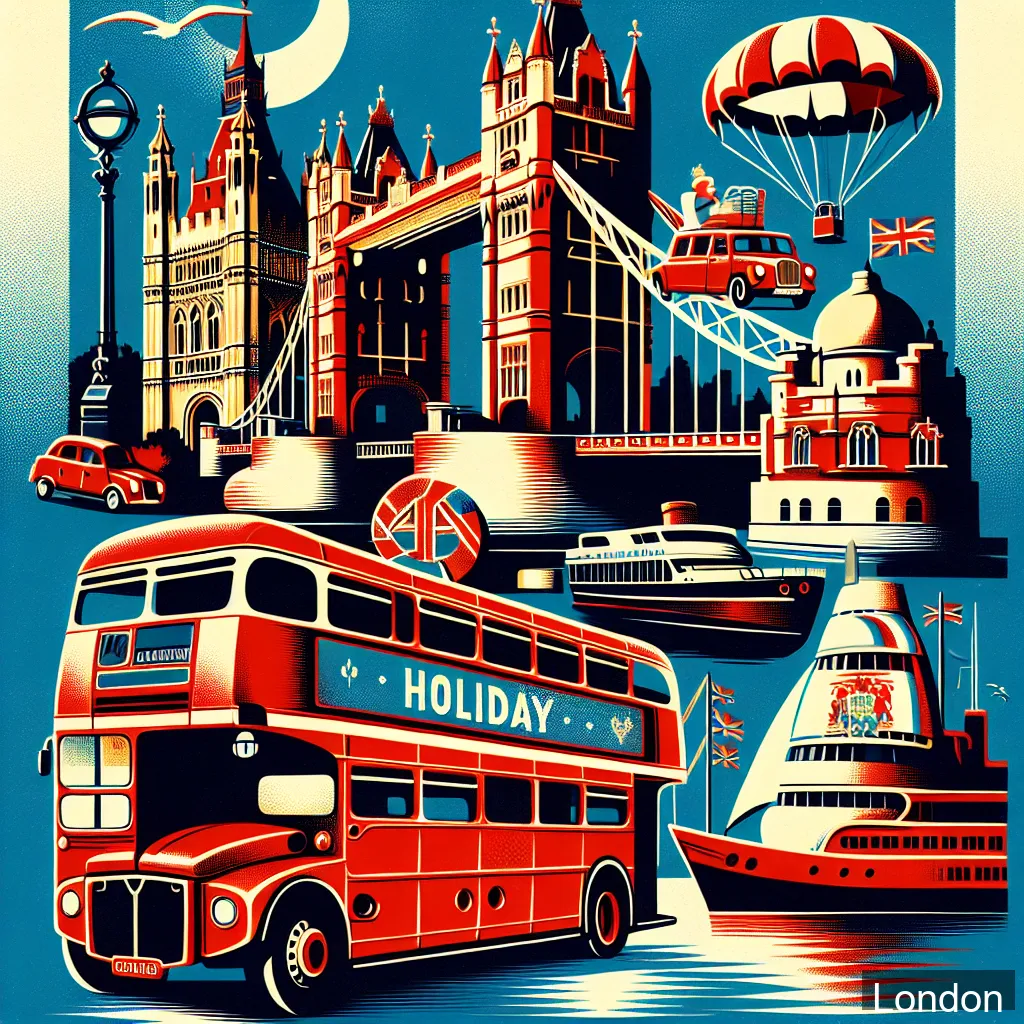

In [18]:
image = artist("New York City")
display(image)

## Audio (NOTE - Audio is optional for this course - feel free to skip Audio if it causes trouble!)

And let's make a function talker that uses OpenAI's speech model to generate Audio

### Troubleshooting Audio issues

If you have any problems running this code below (like a FileNotFound error, or a warning of a missing package), you may need to install FFmpeg, a very popular audio utility.

**For PC Users**

Detailed instructions are [here](https://chatgpt.com/share/6724efee-6b0c-8012-ac5e-72e2e3885905) and summary instructions:

1. Download FFmpeg from the official website: https://ffmpeg.org/download.html

2. Extract the downloaded files to a location on your computer (e.g., `C:\ffmpeg`)

3. Add the FFmpeg bin folder to your system PATH:
- Right-click on 'This PC' or 'My Computer' and select 'Properties'
- Click on 'Advanced system settings'
- Click on 'Environment Variables'
- Under 'System variables', find and edit 'Path'
- Add a new entry with the path to your FFmpeg bin folder (e.g., `C:\ffmpeg\bin`)
- Restart your command prompt, and within Jupyter Lab do Kernel -> Restart kernel, to pick up the changes

4. Open a new command prompt and run this to make sure it's installed OK
`ffmpeg -version`

**For Mac Users**

1. Install homebrew if you don't have it already by running this in a Terminal window and following any instructions:  
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. Then install FFmpeg with `brew install ffmpeg`

3. Verify your installation with `ffmpeg -version` and if everything is good, within Jupyter Lab do Kernel -> Restart kernel to pick up the changes

Message me or email me at ed@edwarddonner.com with any problems!

## To check you now have ffmpeg and can access it here

Excecute the next cell to see if you get a version number. (Putting an exclamation mark before something in Jupyter Lab tells it to run it as a terminal command rather than python code).

If this doesn't work, you may need to actually save and close down your Jupyter lab, and start it again from a new Terminal window (Mac) or Anaconda prompt (PC), remembering to activate the llms environment. This ensures you pick up ffmpeg.

And if that doesn't work, please contact me!

In [19]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 7.1.1-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enable-d3d12va --enable-ffnvcodec --enable-libvpl --enable-nvdec --enable-nvenc --enable-vaapi --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --ena

# For Mac users - and possibly many PC users too

This version should work fine for you. It might work for Windows users too, but you might get a Permissions error writing to a temp file. If so, see the next section!

As always, if you have problems, please contact me! (You could also comment out the audio talker() in the later code if you're less interested in audio generation)

In [20]:
import tempfile
import subprocess
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",    # Also, try replacing onyx with alloy
        input=message
    )

    if hasattr(response, "content"):
        audio_stream = BytesIO(response.content)
        audio = AudioSegment.from_file(audio_stream, format="mp3")
        
        # Manually create a temp file for playback
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmpfile:
            temp_filename = tmpfile.name
        
        try:
            audio.export(temp_filename, format="wav")
            # Call ffplay manually to play it
            subprocess.call(["ffplay", "-nodisp", "-autoexit", "-hide_banner", temp_filename])
        finally:
            # Clean up temp file after playback
            os.remove(temp_filename)

    else:
        print("Failed to get valid audio content.")

In [21]:
talker("Well, hi there")

# For Windows users (or any Mac users with problems above)

## First try the Mac version above, but if you get a permissions error writing to a temp file, then this code should work instead.

A collaboration between students Mark M. and Patrick H. and Claude got this resolved!

Below are 4 variations - hopefully one of them will work on your PC. If not, message me please!

And for Mac people - all 3 of the below work on my Mac too - please try these if the Mac version gave you problems.

## PC Variation 1

In [22]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

## PC Variation 2

In [23]:
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
import time

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(3) # Student Dominic found that this was needed. You could also try commenting out to see if not needed on your PC
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass
 
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play_audio(audio)

talker("Well hi there")

## PC Variation 3

In [24]:
import os
import subprocess
import tempfile
from pydub import AudioSegment
from io import BytesIO
import openai  # Make sure your openai.api_key is set

def talker(message):
    # Create a custom temp folder if needed
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    if not os.path.exists(custom_temp_dir):
        os.makedirs(custom_temp_dir)
    
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # Manually create a temp file and close it first
    with tempfile.NamedTemporaryFile(delete=False, dir=custom_temp_dir, suffix=".wav") as tmpfile:
        temp_filename = tmpfile.name

    try:
        audio.export(temp_filename, format="wav")

        # Use ffplay to play the file
        subprocess.call(["ffplay", "-nodisp", "-autoexit", "-hide_banner", temp_filename])
    finally:
        # Make sure to delete the temp file after playing
        if os.path.exists(temp_filename):
            os.remove(temp_filename)

talker("Well hi there")

## PC Variation 4

### Let's try a completely different sound library

First run the next cell to install a new library, then try the cell below it.

In [25]:
# !pip install simpleaudio

In [26]:
# from pydub import AudioSegment
# from io import BytesIO
# import tempfile
# import os
# import simpleaudio as sa

# def talker(message):
#     response = openai.audio.speech.create(
#         model="tts-1",
#         voice="onyx",  # Also, try replacing onyx with alloy
#         input=message
#     )
    
#     audio_stream = BytesIO(response.content)
#     audio = AudioSegment.from_file(audio_stream, format="mp3")

#     # Create a temporary file in a folder where you have write permissions
#     with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
#         temp_file_name = temp_audio_file.name
#         audio.export(temp_file_name, format="wav")
    
#     # Load and play audio using simpleaudio
#     wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
#     play_obj = wave_obj.play()
#     play_obj.wait_done()  # Wait for playback to finish

#     # Clean up the temporary file afterward
#     os.remove(temp_file_name)
    
# # talker("Well hi there")

## PC Users - if none of those 4 variations worked!

Please get in touch with me. I'm sorry this is causing problems! We'll figure it out.

Alternatively: playing audio from your PC isn't super-critical for this course, and you can feel free to focus on image generation and skip audio for now, or come back to it later.

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [45]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "

### New requirement to accept multi-language ...
system_message += "Users may speak in different languages. Always translate the input into English before processing. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [46]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        tool_name = message.tool_calls[0].function.name

        if tool_name == "get_ticket_price":
            response, city = handle_tool_call(message)
        elif tool_name == "make_booking":
            response, city = handle_tool_call_booking(message)

        messages.extend([message, response])
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]
    
    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

### Translator Search Result to the Languaghe by using GPT or Claude

In [53]:
language = "Chinese"
system_message_translator=f"You are a {language} language assistant. Always translate from English to {language} without adding any extra text"

In [54]:
# Modified translator to accept the whole chat as "history", break it down and translate one messsage at a time 
# to preserve the roles in the output chats so they can be displayed correctly and not as one lumped response from the 
# assistant 
def translate_gpt(history):
    translation=[]
    for item in history:
        messages = [{"role":"system","content":system_message_translator},
                    {"role":"user","content":item.get('content')}]
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
        translation+=[{"role":item.get('role'), "content":response.choices[0].message.content}]
    
    return translation

In [55]:
translate_gpt([{'role': 'user', 'content': 'I am going to Paris'},{'role': 'assistant', 'content': 'The price of a ticket to Paris is $899'}])

[{'role': 'user', 'content': '我将前往巴黎。'},
 {'role': 'assistant', 'content': '飞往巴黎的机票价格为899美元。'}]

In [56]:
# Translator using Claude 
def translate_claude(history):
    translation=[]
    for item in history:
        message = claude.messages.create(
            model=MODEL_TRANSLATE,
            max_tokens=200,
            temperature=0.5,
            system=system_message_translator,
            messages=[
                {"role": "user", "content":item.get('content')},
            ]
        )
        
        translation+=[{"role":item.get('role'), "content":message.content[0].text}]
    
    return translation


In [57]:
translate_claude([{'role': 'user', 'content': 'I am going to London'},{'role': 'assistant', 'content': 'The price of a ticket to Paris is $899'}])

[{'role': 'user', 'content': '我要去伦敦'},
 {'role': 'assistant', 'content': '前往巴黎的机票价格为899美元。'}]

### Convert Audio to Text

In [60]:
system_message_audio="You are an assistant that can convert speech in audio format to text"

In [61]:
# agent that converts audio to text 
def speech_to_text(audio):
    print("In speech to text function")
    messages = [{"role":"system","content":system_message_audio},
                    {"role":"user","content":audio}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    return response.choices[0].message.content

In [62]:
import warnings
warnings.filterwarnings("ignore", message="FP16 is not supported on CPU; using FP32 instead")


In [66]:
# with gr.Blocks() as ui:
#     gr.Markdown("# 🎤 Voice Assistant")
#     gr.Markdown("Please upload or record your voice, and we will transcribe it.")
#     with gr.Row():
#         chatbot_main = gr.Chatbot(height=500, type="messages")
#     with gr.Row():
#         # entry = gr.Textbox(label="Chat with our AI Assistant:")
#         audio_entry=gr.Audio(type="filepath", label="Speak")
    
#     def do_entry (audio, history):
#         if not audio or not os.path.exists(audio):
#             print("Invalid audio ...")
#             try:
#                 return history  # ✅ 保證回傳list，不是None
            
#             except Exception as e:
#                 print(f"Error in do_entry: {e}")  # ✅ 顯示錯誤細節，方便debug
#                 time.sleep(2)  # 暫停 2 秒
#                 return history  # ✅ fallback時也保證是list
                        
#         print("In entry function")
#         transcript = whisper_model.transcribe(audio)["text"]
#         print(f"Transcript: {transcript}")

#         if transcript: 
#             history += [{"role":"user", "content":transcript}]
#             print(history)
            
#         # return "", history  
#         return history

#     audio_entry.change(do_entry, inputs=[audio_entry,chatbot_main], outputs=[chatbot_main]) 

# # ui.launch(inbrowser=True)
# ui.launch()
with gr.Blocks() as ui:
    gr.Markdown("# 🎤 Voice Assistant")
    gr.Markdown("Please upload or record your voice, and we will transcribe it.")

    with gr.Row():
        chatbot_main = gr.Chatbot(height=500, type="messages")
    
    with gr.Row():
        audio_entry = gr.Audio(type="filepath", label="🎙️ Speak")

    def do_entry(audio, history):
        try:
            if not audio or not os.path.exists(audio):
                print("⚠️ Invalid or missing audio file.")
                return history if history else []

            print("🎧 Audio file received. Starting transcription...")
            transcript = whisper_model.transcribe(audio)["text"]
            print(f"📝 Transcript: {transcript}")

            if transcript:
                history = history + [{"role": "user", "content": transcript}]
                print("✅ Updated history:", history)

            return history

        except Exception as e:
            print(f"❌ Exception in do_entry: {e}")
            time.sleep(2)  # Optional: for debugging delays
            return history if history else []

    audio_entry.change(
        do_entry,
        inputs=[audio_entry, chatbot_main],
        outputs=[chatbot_main]
    )

ui.launch()

* Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


🎧 Audio file received. Starting transcription...
📝 Transcript: 去輪端的機票
✅ Updated history: [{'role': 'user', 'content': '去輪端的機票'}]
⚠️ Invalid or missing audio file.
🎧 Audio file received. Starting transcription...
📝 Transcript: 去輪端的機票
✅ Updated history: [{'role': 'user', 'metadata': None, 'content': '去輪端的機票', 'options': None}, {'role': 'user', 'content': '去輪端的機票'}]
⚠️ Invalid or missing audio file.
🎧 Audio file received. Starting transcription...
📝 Transcript: 去紐約的機票
✅ Updated history: [{'role': 'user', 'metadata': None, 'content': '去輪端的機票', 'options': None}, {'role': 'user', 'metadata': None, 'content': '去輪端的機票', 'options': None}, {'role': 'user', 'content': '去紐約的機票'}]
Tool get_ticket_price called for Taipei
Tool get_ticket_price called for Taipei
Tool get_ticket_price called for London


#### FlightAI Text Message Assistant with Translator

In [64]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

import gradio as gr

with gr.Blocks() as ui:
    gr.Markdown("# 🎤 FlightAI Text Message Assistant with Translator")
    gr.Markdown("Enter your message below or click the 'Clear' button to reset the conversation.")

    with gr.Row():
        chatbot_main = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
        chatbot_lang = gr.Chatbot(height=500, type="messages")

    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")

    with gr.Row():
        clear = gr.Button("Clear")

    # Handle text input safely
    def do_entry(message, history):
        try:
            if message:
                history = history + [{"role": "user", "content": message}]
            return "", history
        except Exception as e:
            print(f"[do_entry] Exception: {e}")
            time.sleep(2)  # 暫停 2 秒
            return "", history or []

    # Handle chat response safely
    def safe_chat(history):
        try:
            return chat(history)
        except Exception as e:
            print(f"[chat] Exception: {e}")
            return history, None

    # Handle translation safely
    def safe_translate(history):
        try:
            return translate_claude(history)
        except Exception as e:
            print(f"[translate_claude] Exception: {e}")
            return []

    entry.submit(
        do_entry,
        inputs=[entry, chatbot_main],
        outputs=[entry, chatbot_main]
    ).then(
        safe_chat,
        inputs=chatbot_main,
        outputs=[chatbot_main, image_output]
    ).then(
        safe_translate,
        inputs=chatbot_main,
        outputs=chatbot_lang
    )    

    def clear_chat():
        return [], None, []

    clear.click(clear_chat, outputs=[chatbot_main, image_output, chatbot_lang])

ui.launch()

* Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Taipei


# Final Version - FlightAI Voice Assistance with Translator

In [72]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.
# Audio input

with gr.Blocks() as ui:
    gr.Markdown("# 🎤 FlightAI Voice Assistant with Translator")
    gr.Markdown("Speak or upload your voice, or click the 'Clear' button to reset the conversation.")
    
    with gr.Row():
        chatbot_main = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
        chatbot_lang = gr.Chatbot(height=500, type="messages")
    with gr.Row():
        audio_entry = gr.Audio(type="filepath", label="🎙️ Speak")
    with gr.Row():
        clear = gr.Button("Clear")

    # ✅ Exception-safe audio handler
    def do_entry(audio, history):
        print ("Do entry start ...")
        try:
            if not audio or not os.path.exists(audio):
                print("⚠️ No audio file found.")
                return history, None
            
            transcript = whisper_model.transcribe(audio)["text"]
            print(f"🎧 Transcript: {transcript}")

            if transcript:
                history = history + [{"role": "user", "content": transcript}]

            print ("Do entry end ...")
            return history, None

        except Exception as e:
            print(f"⚠️ Error in do_entry(): {e}")
            return history, None # Fallback to original chat history on failure

    # Main logic chain
    audio_entry.change(
        do_entry,
        inputs=[audio_entry, chatbot_main],
        outputs=[chatbot_main, audio_entry]  # ✅ Match return history, None
    ).then(
        chat,
        inputs=chatbot_main,
        outputs=[chatbot_main, image_output]
    ).then(
        translate_claude,
        inputs=chatbot_main,
        outputs=chatbot_lang
    )

    # Clear button handler
    def clear_chat():
        return [], None, [], None

    clear.click(
        clear_chat,
        outputs=[chatbot_main, image_output, chatbot_lang, audio_entry]
    )

ui.launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


Do entry start ...
🎧 Transcript: 到台北的機票
Do entry end ...
Do entry start ...
⚠️ No audio file found.
Tool get_ticket_price called for Taipei
Do entry start ...
🎧 Transcript: 到纽约的机票
Do entry end ...
Do entry start ...
⚠️ No audio file found.
Tool get_ticket_price called for New York


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "D:\development\llm_engineering\venv\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 409, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        self.scope, self.receive, self.send
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "D:\development\llm_engineering\venv\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\development\llm_engineering\venv\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "D:\development\llm_engineering\venv\Lib\site-packages\starlette\applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "D:\development\llm_engineer

Do entry start ...
🎧 Transcript: 那風晶的機票
Do entry end ...
Do entry start ...
⚠️ No audio file found.
Tool get_ticket_price called for Fengjing
Do entry start ...
🎧 Transcript: 上東京的機票
Do entry end ...
Do entry start ...
⚠️ No audio file found.
Tool get_ticket_price called for Tokyo


# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>